In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')

In [8]:
print("\n" + "="*60)
print("LOADING DATA")
print("="*60)

TICKER = 'AAPL'

# Load data with Date column
data = pd.read_csv(f'../data/{TICKER}_stock_data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

print(f"\n✅ Loaded {len(data)} rows of data")
print(f"📅 Date range: {str(data.index[0])[:10]} to {str(data.index[-1])[:10]}")

print("\n📋 Original data:")
print(data.head())


LOADING DATA

✅ Loaded 1010 rows of data
📅 Date range: 2022-01-03 to 2026-01-12

📋 Original data:
                 Close        High         Low        Open     Volume
Date                                                                 
2022-01-03  178.270325  179.122459  174.058687  174.176216  104487900
2022-01-04  176.007782  179.181217  175.439697  178.877588   99310400
2022-01-05  171.326019  176.468151  171.051773  175.919659   94537600
2022-01-06  168.465958  171.698156  168.113354  169.151572   96904000
2022-01-07  168.632507  170.562032  167.515931  169.337715   86709100


In [10]:
print("\n" + "="*60)
print("CREATING NEW FEATURES")
print("="*60)

df = data.copy()

# Feature 1: Moving Averages (smoothed price trends)
print("\n1️⃣ Creating moving averages...")
df['MA_7'] = df['Close'].rolling(window=7).mean()
df['MA_30'] = df['Close'].rolling(window=30).mean()
print("   ✅ MA_7, MA_30")

# Feature 2: Lag Features (previous day values)
print("\n2️⃣ Creating lag features...")
df['Close_Lag_1'] = df['Close'].shift(1)  # Yesterday's price
df['Close_Lag_3'] = df['Close'].shift(3)  # 3 days ago
df['Close_Lag_7'] = df['Close'].shift(7)  # 1 week ago
print("   ✅ Close_Lag_1, Close_Lag_3, Close_Lag_7")

# Feature 3: Price Changes
print("\n3️⃣ Creating price change features...")
df['Price_Change'] = df['Close'].pct_change() * 100  # Daily % change
df['Price_Momentum_3'] = ((df['Close'] - df['Close'].shift(3)) / df['Close'].shift(3)) * 100
print("   ✅ Price_Change, Price_Momentum_3")

# Feature 4: Volume Features
print("\n4️⃣ Creating volume features...")
df['Volume_Change'] = df['Volume'].pct_change() * 100
df['Volume_MA_7'] = df['Volume'].rolling(window=7).mean()
df['Volume_Ratio'] = df['Volume'] / df['Volume_MA_7']
print("   ✅ Volume_Change, Volume_MA_7, Volume_Ratio")

# Feature 5: Volatility (price range)
print("\n5️⃣ Creating volatility features...")
df['Daily_Volatility'] = df['High'] - df['Low']
df['ATR_7'] = df['Daily_Volatility'].rolling(window=7).mean()
print("   ✅ Daily_Volatility, ATR_7")

# Feature 6: Additional Features
print("\n6️⃣ Creating additional features...")
df['Gap'] = df['Open'] - df['Close'].shift(1)
df['Gap_Percent'] = (df['Gap'] / df['Close'].shift(1)) * 100
print("   ✅ Gap, Gap_Percent")

print(f"\n✅ Created {len(df.columns) - len(data.columns)} new features!")


CREATING NEW FEATURES

1️⃣ Creating moving averages...
   ✅ MA_7, MA_30

2️⃣ Creating lag features...
   ✅ Close_Lag_1, Close_Lag_3, Close_Lag_7

3️⃣ Creating price change features...
   ✅ Price_Change, Price_Momentum_3

4️⃣ Creating volume features...
   ✅ Volume_Change, Volume_MA_7, Volume_Ratio

5️⃣ Creating volatility features...
   ✅ Daily_Volatility, ATR_7

6️⃣ Creating additional features...
   ✅ Gap, Gap_Percent

✅ Created 14 new features!


In [12]:
print("\n" + "="*60)
print("CREATING TARGET")
print("="*60)

print("\n Target = What we want to predict (tomorrow's price)")

df['Target'] = df['Close'].shift(-1)  # Next day's closing price

print("\n📊 Example:")
print(df[['Close', 'Target']].tail(5))
print("\n   Notice: Target shows the NEXT day's price")


CREATING TARGET

 Target = What we want to predict (tomorrow's price)

📊 Example:
                 Close      Target
Date                              
2026-01-06  262.359985  260.329987
2026-01-07  260.329987  259.040009
2026-01-08  259.040009  259.369995
2026-01-09  259.369995  260.250000
2026-01-12  260.250000         NaN

   Notice: Target shows the NEXT day's price


In [13]:
print("\n" + "="*60)
print("CLEANING DATA")
print("="*60)

print(f"\n🔍 Missing values: {df.isnull().sum().sum()}")
print("   (Moving averages and lag features create missing values at the start)")

# Remove rows with missing values
df_clean = df.dropna()

print(f"\n✅ Clean dataset:")
print(f"   Before: {len(df)} rows")
print(f"   After: {len(df_clean)} rows")
print(f"   Removed: {len(df) - len(df_clean)} rows")


CLEANING DATA

🔍 Missing values: 72
   (Moving averages and lag features create missing values at the start)

✅ Clean dataset:
   Before: 1010 rows
   After: 980 rows
   Removed: 30 rows


In [14]:
print("\n" + "="*60)
print("SELECTING FEATURES")
print("="*60)

# Choose the most important features
selected_features = [
    'Close_Lag_1',      # Yesterday's price
    'MA_7',             # Short-term trend
    'MA_30',            # Long-term trend
    'Price_Change',     # Daily momentum
    'Volume_Change',    # Volume change
    'Daily_Volatility', # Price range
    'Volume_Ratio',     # Volume activity
    'Price_Momentum_3', # 3-day trend
    'ATR_7',           # Average volatility
    'Gap_Percent'      # Opening gap
]

print(f"\n📋 Selected {len(selected_features)} features:")
for i, feature in enumerate(selected_features, 1):
    print(f"   {i}. {feature}")

# Create final dataset
final_columns = selected_features + ['Target']
df_final = df_clean[final_columns].copy()

print(f"\n✅ Final dataset shape: {df_final.shape}")
print(f"   ({df_final.shape[0]} samples, {df_final.shape[1]-1} features + 1 target)")


SELECTING FEATURES

📋 Selected 10 features:
   1. Close_Lag_1
   2. MA_7
   3. MA_30
   4. Price_Change
   5. Volume_Change
   6. Daily_Volatility
   7. Volume_Ratio
   8. Price_Momentum_3
   9. ATR_7
   10. Gap_Percent

✅ Final dataset shape: (980, 11)
   (980 samples, 10 features + 1 target)



VISUALIZING FEATURES


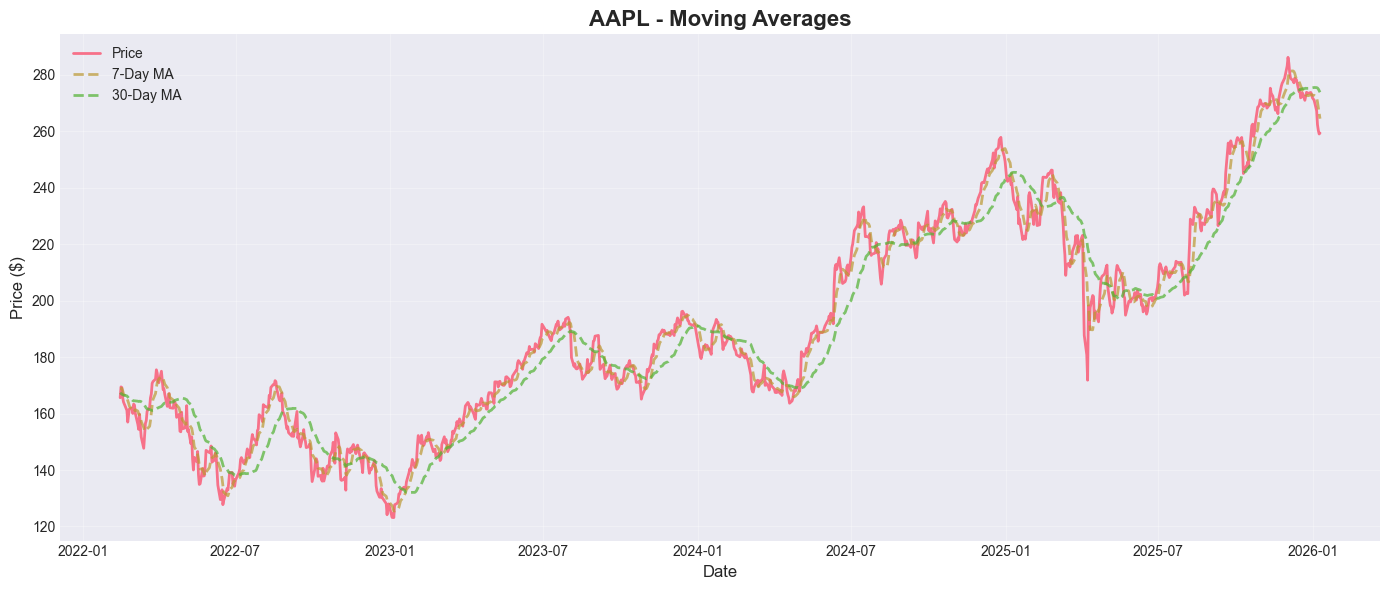

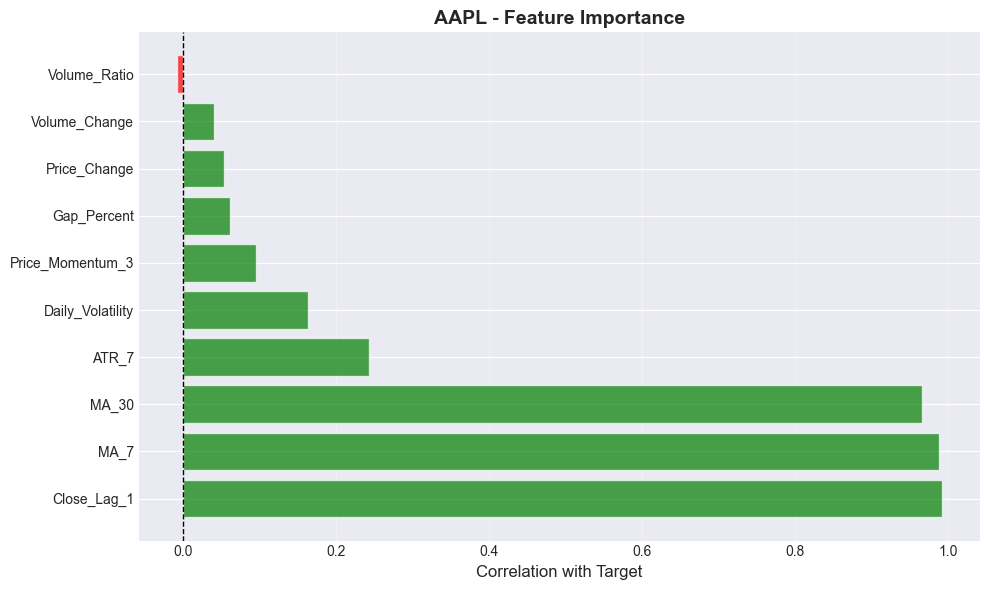


📊 Feature Correlations with Target:
Close_Lag_1         0.992
MA_7                0.989
MA_30               0.967
ATR_7               0.244
Daily_Volatility    0.163
Price_Momentum_3    0.095
Gap_Percent         0.062
Price_Change        0.054
Volume_Change       0.040
Volume_Ratio       -0.007
Name: Target, dtype: float64


In [15]:
print("\n" + "="*60)
print("VISUALIZING FEATURES")
print("="*60)

# Plot 1: Moving Averages
plt.figure(figsize=(14, 6))
plt.plot(df_clean.index, df_clean['Close'], label='Price', linewidth=2)
plt.plot(df_clean.index, df_clean['MA_7'], label='7-Day MA',
         linewidth=2, linestyle='--', alpha=0.7)
plt.plot(df_clean.index, df_clean['MA_30'], label='30-Day MA',
         linewidth=2, linestyle='--', alpha=0.7)
plt.title(f'{TICKER} - Moving Averages', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'../data/{TICKER}_features_ma.png', dpi=300)
plt.show()


# Plot 2: Feature Correlation with Target
correlations = df_final.corr()['Target'].sort_values(ascending=False)
correlations = correlations[1:]  # Remove Target itself

plt.figure(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in correlations.values]
plt.barh(range(len(correlations)), correlations.values, color=colors, alpha=0.7)
plt.yticks(range(len(correlations)), correlations.index)
plt.xlabel('Correlation with Target', fontsize=12)
plt.title(f'{TICKER} - Feature Importance', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig(f'../data/{TICKER}_feature_importance.png', dpi=300)
plt.show()


print("\n📊 Feature Correlations with Target:")
print(correlations.round(3))

In [16]:
print("\n" + "="*60)
print("SAVING DATA")
print("="*60)

# Save the final dataset for Phase 3
output_file = f'../data/{TICKER}_featured_data.csv'
df_final.to_csv(output_file)

print(f"💾 Saved to: {output_file}")

# Also save all features
full_output = f'../data/{TICKER}_all_features.csv'
df_clean.to_csv(full_output)
print(f"💾 Saved complete data to: {full_output}")


SAVING DATA
💾 Saved to: ../data/AAPL_featured_data.csv
💾 Saved complete data to: ../data/AAPL_all_features.csv


In [21]:
print(f"""
Feature Engineering Summary:
   - Created {len(df_clean.columns) - len(data.columns)} new features
   - Selected {len(selected_features)} best features
   - Final dataset: {len(df_final)} samples

Files saved:
   - {output_file}
   - {full_output}
   - 2 visualization charts

Top 3 Most Important Features:
   1. {correlations.index[0]}: {correlations.values[0]:.3f}
   2. {correlations.index[1]}: {correlations.values[1]:.3f}
   3. {correlations.index[2]}: {correlations.values[2]:.3f}
""")


Feature Engineering Summary:
   - Created 15 new features
   - Selected 10 best features
   - Final dataset: 980 samples

Files saved:
   - ../data/AAPL_featured_data.csv
   - ../data/AAPL_all_features.csv
   - 2 visualization charts

Top 3 Most Important Features:
   1. Close_Lag_1: 0.992
   2. MA_7: 0.989
   3. MA_30: 0.967

